### Environment Setup

In [4]:
%pip install findspark

  Obtaining dependency information for findspark from https://files.pythonhosted.org/packages/a4/cb/7d2bb508f4ca00a043fd53e8156c11767799d3f534bf451a0942211d5def/findspark-2.0.1-py2.py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


###  Set up Spark in  local IDE: Jupyter Notebook

In [1]:
import os
import findspark

os.environ["SPARK_HOME"] = "C:\\spark" 
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Retail Big Data Assignment").getOrCreate()

### Load  Dataset

In [48]:
# Load datasets
retail = spark.read.csv("retailstore_large.csv", header=True, inferSchema=True)
customers = spark.read.csv("store_customers.csv", header=True, inferSchema=True)
transactions = spark.read.csv("store_transactions.csv", header=True, inferSchema=True)

In [49]:
# Show first 5 rows of each
print("Retail Dataset:")
retail.show(5)

print("Customers Dataset:")
customers.show(5)

print("Transactions Dataset:")
transactions.show(5)

Retail Dataset:
+----------+----+------+------+-------+
|CustomerID| Age|Salary|Gender|Country|
+----------+----+------+------+-------+
|         1|18.0| 20000|  Male|Germany|
|         2|19.0| 22000|Female| France|
|         3|20.0| 24000|Female|England|
|         4|21.0|  2600|  Male|England|
|         5|22.0| 50000|  Male| France|
+----------+----+------+------+-------+
only showing top 5 rows

Customers Dataset:
+----------+---+------+------+-------+
|CustomerID|Age|Salary|Gender|Country|
+----------+---+------+------+-------+
|         1| 72| 20000|  Male|Germany|
|         2| 72| 22000|Female| France|
|         3| 70| 24000|Female|England|
|         4| 75|  2600|  Male|England|
|         5| 33| 50000|  Male| France|
+----------+---+------+------+-------+
only showing top 5 rows

Transactions Dataset:
+----------+---------+------+----------+
|CustomerID|ProductID|Amount|      Date|
+----------+---------+------+----------+
|      3427|        3|  7541|22-11-2019|
|      4378|      

### Data Processing Using Spark

In [51]:
from pyspark.sql.functions import col, sum, when

# Function to count nulls in each column of a DataFrame
def count_nulls(df, df_name):
    print(f"Null values in '{df_name}' DataFrame:")
    df.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns]).show()

# Function to count duplicate rows in a DataFrame
def count_duplicates(df, df_name):
    duplicate_count = df.groupBy(df.columns).count().filter("count > 1").count()
    print(f"Number of duplicate rows in '{df_name}' DataFrame: {duplicate_count}")

# Check nulls
count_nulls(retail, "retail")
count_nulls(customers, "customers")
count_nulls(retail, "transactions")

# Check duplicates
count_duplicates(retail, "retail")
count_duplicates(customers, "customers")
count_duplicates(retail, "transactions")

Null values in 'retail' DataFrame:
+----------+---+------+------+-------+
|CustomerID|Age|Salary|Gender|Country|
+----------+---+------+------+-------+
|         0|  0|     0|     0|      0|
+----------+---+------+------+-------+

Null values in 'customers' DataFrame:
+----------+---+------+------+-------+
|CustomerID|Age|Salary|Gender|Country|
+----------+---+------+------+-------+
|         0|  0|     0|     0|      0|
+----------+---+------+------+-------+

Null values in 'transactions' DataFrame:
+----------+---+------+------+-------+
|CustomerID|Age|Salary|Gender|Country|
+----------+---+------+------+-------+
|         0|  0|     0|     0|      0|
+----------+---+------+------+-------+

Number of duplicate rows in 'retail' DataFrame: 0
Number of duplicate rows in 'customers' DataFrame: 0
Number of duplicate rows in 'transactions' DataFrame: 0


### Join Datasets

In [50]:
# Correct join between transactions and customers
df = transactions.join(customers, on="CustomerID", how="inner")

df.printSchema()
df.show(5)

root
 |-- CustomerID: integer (nullable = true)
 |-- ProductID: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Salary: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Country: string (nullable = true)

+----------+---------+------+----------+---+------+------+-------+
|CustomerID|ProductID|Amount|      Date|Age|Salary|Gender|Country|
+----------+---------+------+----------+---+------+------+-------+
|      3427|        3|  7541|22-11-2019| 69| 14300|Female|England|
|      4378|       14|  7271|15-12-2019| 78| 42000|  Male|Germany|
|      3751|       47|  4276|20-11-2019| 57| 45000|Female|England|
|      6899|      146|  8923|22-11-2019| 34| 12600|  Male|Germany|
|      4561|       46|  4891|30-11-2019| 37| 50000|Female|Germany|
+----------+---------+------+----------+---+------+------+-------+
only showing top 5 rows



### Create a Temp View and Run SQL

In [53]:
# Register DataFrame as a Hive-compatible table
df.createOrReplaceTempView("retail_data")

#### HiveQL Query 1: Total sales by country

In [62]:
print("✅ Total Sales by Country")
spark.sql("""
    SELECT Country, SUM(Amount) AS TotalSales
    FROM retail_data
    GROUP BY Country
    ORDER BY TotalSales DESC
""").show()

✅ Total Sales by Country
+-------+----------+
|Country|TotalSales|
+-------+----------+
|England| 230855023|
| France| 145868556|
|Germany| 134377551|
+-------+----------+



#### HiveQL Query 2: Month-wise Sales Trend in 2019

In [61]:
from pyspark.sql.functions import to_date, date_format

# Parse date string to DateType first
df = df.withColumn("Date", to_date("Date", "dd-MM-yyyy"))

# Then extract Year-Month for grouping
df = df.withColumn("Month", date_format("Date", "yyyy-MM"))

# Re-register temp view with updated column
df.createOrReplaceTempView("retail_data")

print("✅ Month-wise Sales Trend")
spark.sql("""
    SELECT Month, SUM(Amount) AS TotalSales
    FROM retail_data
    WHERE Month IS NOT NULL
    GROUP BY Month
    ORDER BY Month
""").show(truncate=False)


✅ Month-wise Sales Trend
+-------+----------+
|Month  |TotalSales|
+-------+----------+
|2019-11|219739916 |
|2019-12|291361214 |
+-------+----------+



####  HiveQL Query 3: Gender-wise transaction count

In [58]:
print("Transaction Count by Gender")
spark.sql("""
    SELECT Gender, COUNT(*) AS TransactionCount
    FROM retail_data
    GROUP BY Gender
""").show()

Transaction Count by Gender
+------+----------------+
|Gender|TransactionCount|
+------+----------------+
|Female|           49524|
|  Male|           52985|
+------+----------------+



#### HiveQL Query 4: Top 5 high-value customers

In [59]:
print("Top 5 Customers by Total Spending")
spark.sql("""
    SELECT CustomerID, SUM(Amount) AS TotalSpent
    FROM retail_data
    GROUP BY CustomerID
    ORDER BY TotalSpent DESC
    LIMIT 5
""").show()

Top 5 Customers by Total Spending
+----------+----------+
|CustomerID|TotalSpent|
+----------+----------+
|      5293|    170384|
|      5535|    157920|
|      4201|    156737|
|      1293|    154980|
|      1087|    150911|
+----------+----------+



### ML Model: Predicting High-Spending Customers

divide high and low spending customers by setting a threshold on the Amount field, e.g., Amount > 5000 for high spending and <= 5000 for low spending.

In [189]:
from pyspark.sql.functions import when
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

#  Create label column
df_ml = df.withColumn("label", when(df.Amount > 5000, 1).otherwise(0))

#  Encode categorical feature
df_ml = StringIndexer(inputCol="Gender", outputCol="GenderIndex").fit(df_ml).transform(df_ml)

#  Assemble features
assembler = VectorAssembler(
    inputCols=["Age", "Salary", "GenderIndex"],
    outputCol="features"
)
data = assembler.transform(df_ml).select("features", "label")

### Train-Test Split & Model Training

In [198]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

In [199]:
print("First 5 rows of the training data:")
train_data.show(5)

print("First 5 rows of the testing data:")
test_data.show(5)


First 5 rows of the training data:
+-----------------+-----+
|         features|label|
+-----------------+-----+
|[20.0,7600.0,0.0]|    0|
|[20.0,7600.0,0.0]|    0|
|[20.0,7600.0,0.0]|    0|
|[20.0,7600.0,0.0]|    0|
|[20.0,7600.0,0.0]|    0|
+-----------------+-----+
only showing top 5 rows

First 5 rows of the testing data:
+-----------------+-----+
|         features|label|
+-----------------+-----+
|[20.0,7600.0,0.0]|    0|
|[20.0,7600.0,0.0]|    1|
|[20.0,7600.0,0.0]|    1|
|[20.0,7600.0,0.0]|    1|
|[20.0,7600.0,1.0]|    0|
+-----------------+-----+
only showing top 5 rows



### Decision Tree Model Implementation

In [197]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    labelCol="label", 
    featuresCol="features", 
    maxDepth=5, 
    minInstancesPerNode=20
)

dt_model = dt.fit(train_data)

predictions = dt_model.transform(test_data)

### Evaluation (Accuracy, Precision, Recall, F1, ROC)

In [195]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

print("=== Decision Tree Classification Results ===")

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
precision = evaluator.setMetricName("precisionByLabel").setMetricLabel(1).evaluate(predictions)
recall = evaluator.setMetricName("recallByLabel").setMetricLabel(1).evaluate(predictions)  # Fixed typo
f1 = evaluator.setMetricName("f1").evaluate(predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Binary Evaluator for AUC
roc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = roc.evaluate(predictions)
print(f"ROC AUC:   {auc:.4f}")

=== Decision Tree Classification Results ===
Accuracy:  0.6973
Precision: 0.6973
Recall:    0.6973
F1 Score:  0.5729
ROC AUC:   0.5000


### Confusion matrix

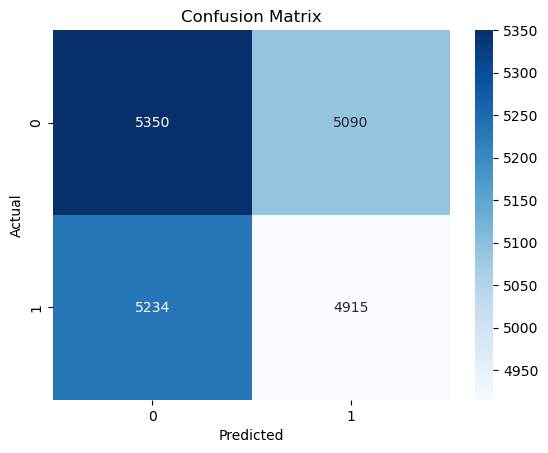

In [144]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Convert to pandas
cm = dt_predictions.select("label", "prediction").toPandas()

# Force all labels to appear
labels = [0, 1]
cf_matrix = confusion_matrix(cm['label'], cm['prediction'], labels=labels)

# Plot
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Feature importance

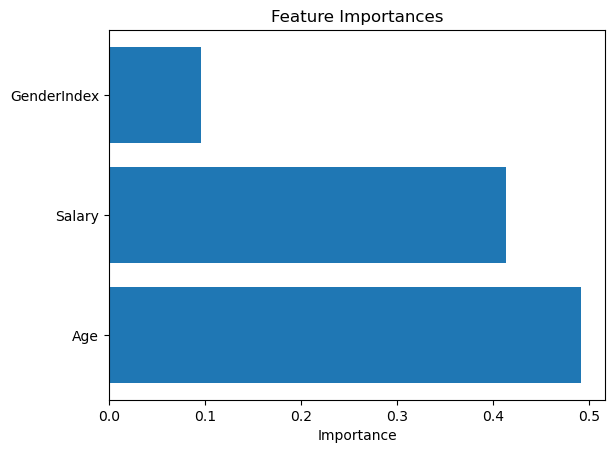

In [140]:
import matplotlib.pyplot as plt

# Feature importance
importances = rf_model.featureImportances.toArray()
features = ["Age", "Salary", "GenderIndex"]

plt.barh(features, importances)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.show()

### AUC-ROC Curve

In [147]:
# Extract the probability of class 1 from the probability vector
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType

# UDF to extract class-1 probability
get_prob = udf(lambda v: float(v[1]), DoubleType())
preds = predictions.withColumn("probability_1", get_prob(col("probability")))


In [148]:
# Convert to Pandas
roc_data = preds.select("probability_1", "label").toPandas()

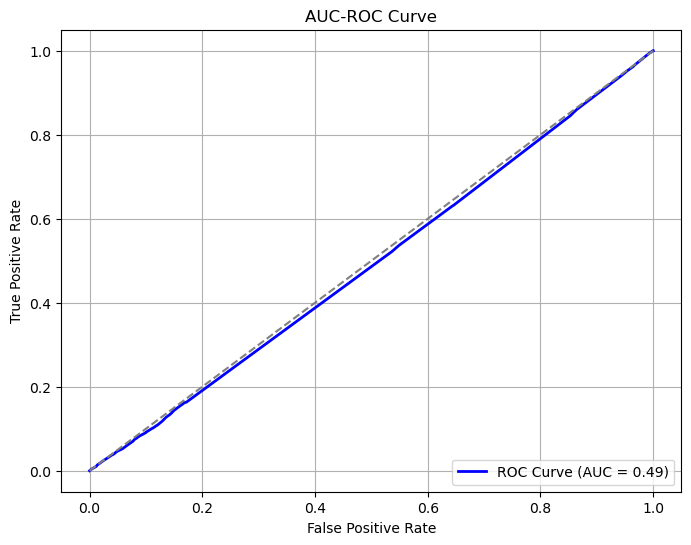

In [149]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(roc_data['label'], roc_data['probability_1'])
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
